Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

![skip-gram_CBOW](./pictures/skip-gram_CBOW.jpg)

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [4]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [5]:
print(collections.Counter(words[:100]))
print(collections.Counter(words[:100]).most_common(10))

Counter({'the': 9, 'a': 4, 'of': 4, 'used': 3, 'is': 3, 'as': 3, 'anarchism': 3, 'are': 2, 'term': 2, 'revolution': 2, 'and': 2, 'that': 2, 'to': 2, 'diggers': 1, 'unnecessary': 1, 'first': 1, 'taken': 1, 'differing': 1, 'including': 1, 'abolished': 1, 'pejorative': 1, 'rulers': 1, 'there': 1, 'class': 1, 'king': 1, 'culottes': 1, 'society': 1, 'abuse': 1, 'it': 1, 'label': 1, 'philosophy': 1, 'positive': 1, 'archons': 1, 'been': 1, 'word': 1, 'self': 1, 'english': 1, 'violent': 1, 'working': 1, 'describe': 1, 'chief': 1, 'without': 1, 'destroy': 1, 'french': 1, 'up': 1, 'has': 1, 'originated': 1, 'belief': 1, 'anarchists': 1, 'radicals': 1, 'defined': 1, 'be': 1, 'should': 1, 'ruler': 1, 'against': 1, 'greek': 1, 'whilst': 1, 'in': 1, 'act': 1, 'way': 1, 'early': 1, 'sans': 1, 'although': 1, 'derived': 1, 'by': 1, 'still': 1, 'organization': 1, 'any': 1, 'from': 1, 'political': 1, 'means': 1, 'also': 1})
[('the', 9), ('a', 4), ('of', 4), ('used', 3), ('is', 3), ('as', 3), ('anarchism'

In [7]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3135, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

- skip_window: 从当前input word的一侧（左边或右边）选取词的数量
- num_skips: 从整个窗口中选取多少个不同的词作为我们的output word

下图为skip_window=2, num_skips=4的示例
![skip-gram](./pictures/skip-gram.png)

In [15]:
print(collections.deque(maxlen=5))

deque([], maxlen=5)


In [8]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]窗口大小
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'a', 'originated', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'term', 'originated', 'a', 'term', 'originated', 'of', 'as']


Train a skip-gram model.

![word2vec](./pictures/word2vec.png)

In [25]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  # embedding_lookup()用法: http://blog.csdn.net/u013041398/article/details/60955847
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  print(embed.shape)
  print(softmax_weights.shape)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

(128, 128)
(50000, 128)


In [18]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.099648
Nearest to can: euphrates, yod, participate, murakami, dared, novellas, brigham, grouse,
Nearest to by: fainting, calabria, oldcastle, hermon, acute, merv, qed, otherwise,
Nearest to are: diver, lusitani, greyhounds, pital, keanu, infertility, find, retitled,
Nearest to eight: toy, alcohol, cmm, strengths, radius, kuti, corman, fielders,
Nearest to american: todd, assemblages, undergraduate, offshoots, crashed, brick, fairy, hotline,
Nearest to about: assimilated, rearranging, alhazred, saline, gimlin, saba, greens, nunnery,
Nearest to as: incan, scam, bledsoe, incarceration, carriages, croesus, freeh, leander,
Nearest to four: psychologist, fortune, meteorological, boom, cet, expanse, arlen, retroflex,
Nearest to the: twinning, arsenic, paints, pancho, introspective, yasser, lithographic, ata,
Nearest to its: caapi, elects, hematite, complete, dragoon, chen, worry, wahhabism,
Nearest to during: column, avengers, negroponte, superstardom, ma

Average loss at step 52000: 3.434062
Average loss at step 54000: 3.428220
Average loss at step 56000: 3.434463
Average loss at step 58000: 3.400735
Average loss at step 60000: 3.395421
Nearest to can: may, could, will, would, must, should, might, cannot,
Nearest to by: through, under, with, was, without, landform, be, qe,
Nearest to are: were, is, have, surfer, include, including, these, doc,
Nearest to eight: nine, six, seven, four, five, three, zero, two,
Nearest to american: british, russian, australian, austrian, german, italian, english, canadian,
Nearest to about: over, rearranging, wladislaus, judicious, bassists, climber, irenaeus, around,
Nearest to as: lucrezia, similarly, fulbright, voluntarily, barada, disguises, hemorrhagic, chandler,
Nearest to four: five, eight, seven, six, three, nine, zero, two,
Nearest to the: its, their, a, this, his, any, kandahar, these,
Nearest to its: their, his, the, her, freshly, lupercalia, telegrams, tori,
Nearest to during: after, before, in

### tSNE可视化

In [30]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

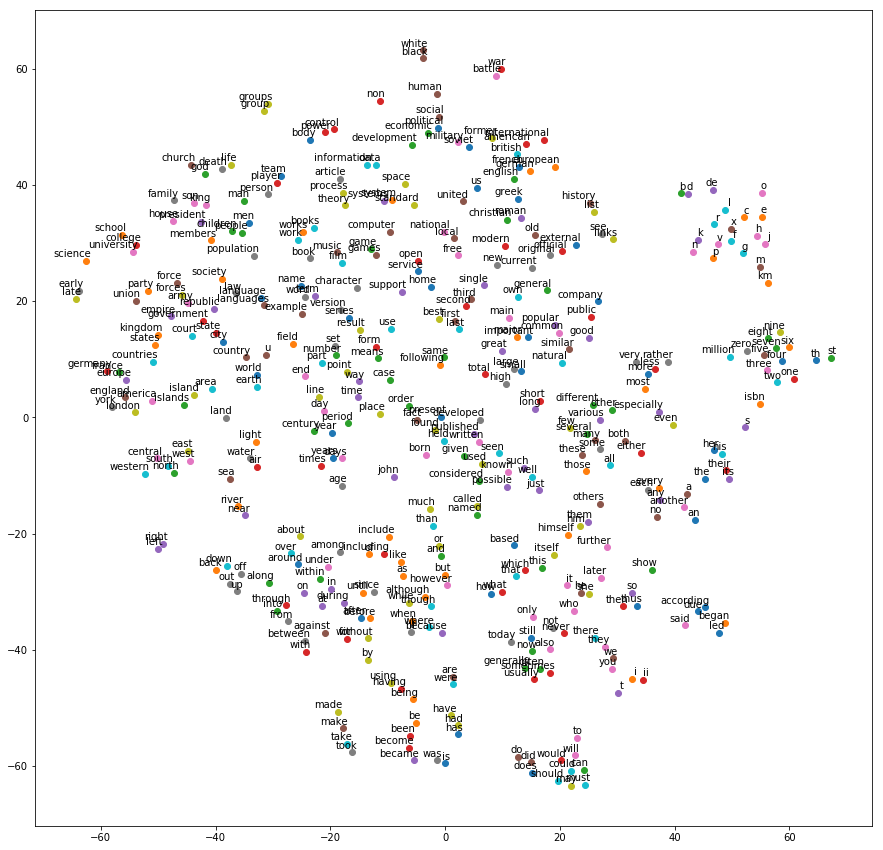

In [31]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [9]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]窗口大小
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[target]
      labels[i * num_skips + j, 0] = buffer[skip_window]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['anarchism', 'as', 'originated', 'a', 'term', 'as', 'a', 'of']
    labels: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']

with num_skips = 4 and skip_window = 2:
    batch: ['anarchism', 'a', 'originated', 'term', 'originated', 'term', 'of', 'as']
    labels: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']


In [10]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  # embedding_lookup()用法: http://blog.csdn.net/u013041398/article/details/60955847
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  print(embed.shape)
  print(softmax_weights.shape)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

(128, 128)
(50000, 128)


In [11]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.153244
Nearest to its: cretinism, realignment, kenjutsu, insurgency, vinton, rhineland, repositories, mishna,
Nearest to as: envisaged, phenomenology, licensed, q, ghibellines, yoshida, geoid, dacia,
Nearest to war: sliced, habib, whiskers, coronae, positioned, crumble, unload, demonstration,
Nearest to been: bmj, atoms, donner, dct, alfons, luminosity, duodecimal, fervent,
Nearest to have: hume, islamists, smashed, sourceforge, programmable, rampart, thrax, korn,
Nearest to not: gian, siege, seraphim, dignitaries, fontsize, gaspar, teen, hesitate,
Nearest to five: spool, phraseology, conferring, interchangeability, cab, inordinate, occuring, peek,
Nearest to three: magick, flair, ferromagnetism, fend, papacy, sufferings, heliocentric, cornwallis,
Nearest to can: loach, outspoken, nicodemus, provers, laughing, pacifists, trypanosoma, dkk,
Nearest to there: predestination, sandals, unifil, aasen, gotovina, mill, subways, immanence,
Nearest to first:

Average loss at step 52000: 3.434896
Average loss at step 54000: 3.427428
Average loss at step 56000: 3.440122
Average loss at step 58000: 3.399659
Average loss at step 60000: 3.394801
Nearest to its: their, his, the, her, bestseller, obadiah, our, abiding,
Nearest to as: envisaged, when, basalt, import, rosette, drowns, ramakrishna, theologically,
Nearest to war: median, obtaining, factbook, antlers, orphan, cogito, abodes, imbalances,
Nearest to been: become, be, was, luminosity, already, were, suffered, had,
Nearest to have: had, has, were, are, having, include, be, vanes,
Nearest to not: still, usually, now, they, never, filter, it, t,
Nearest to five: four, six, three, seven, eight, nine, zero, two,
Nearest to three: five, four, seven, eight, six, two, nine, one,
Nearest to can: may, could, would, will, must, should, cannot, might,
Nearest to there: they, it, this, he, still, she, now, often,
Nearest to first: last, second, next, third, final, same, only, present,
Nearest to while

In [12]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

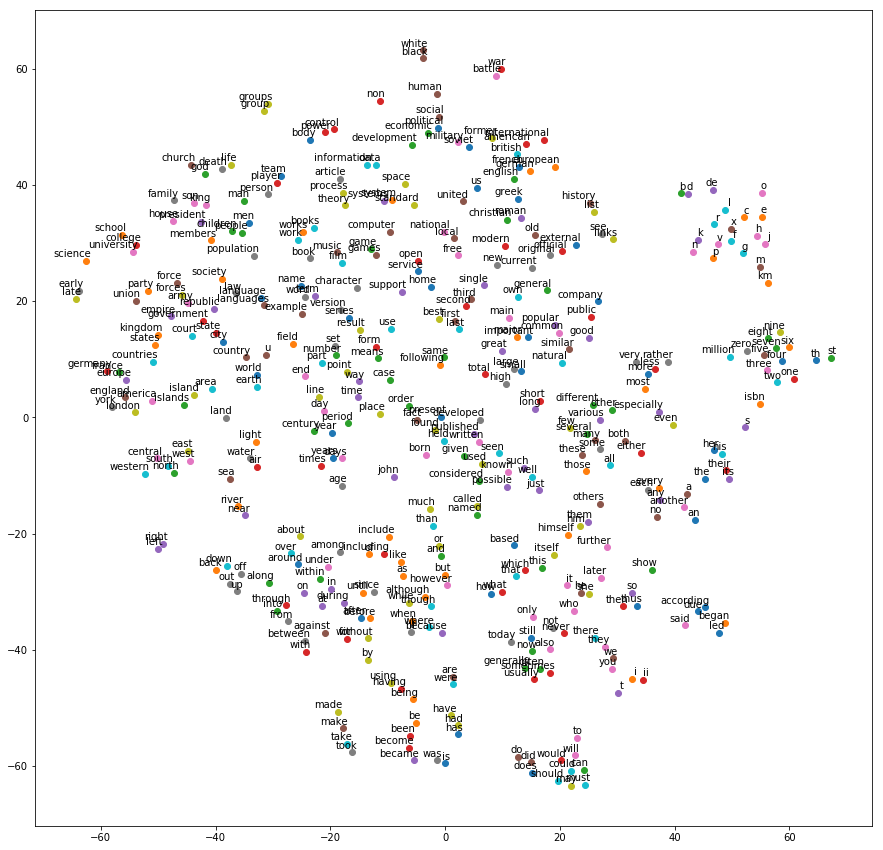

In [31]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [78]:
data_index = 0

def generate_batch(batch_size, bag_window):
  global data_index
 # num_skips = 2 * bag_window
  batch = np.ndarray(shape=(batch_size, 2 * bag_window), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * bag_window + 1 # [ bag_window label bag_window ]窗口大小
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
#  print(batch_size, num_skips)
  for i in range(batch_size):
    target = bag_window  # target label at the center of the buffer
    targets_to_avoid = [ bag_window ]
    for j in range(2 * bag_window):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      #print(reverse_dictionary[buffer[target]])
      batch[i, j] = buffer[target]
    labels[i, 0] = buffer[bag_window]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:10]])

for bag_window in [1, 2]:
    data_index = 0 
    batch, labels = generate_batch(batch_size=8, bag_window=bag_window)
    print('\nwith bag_window = %d:' % (bag_window))
    print('    batch:', [[reverse_dictionary[i] for i in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']

with bag_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['of', 'a'], ['term', 'abuse'], ['first', 'of'], ['used', 'abuse'], ['against', 'first']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with bag_window = 2:
    batch: [['originated', 'term', 'anarchism', 'a'], ['originated', 'of', 'term', 'as'], ['as', 'of', 'abuse', 'a'], ['a', 'first', 'abuse', 'term'], ['term', 'first', 'used', 'of'], ['abuse', 'of', 'used', 'against'], ['first', 'against', 'abuse', 'early'], ['early', 'working', 'used', 'first']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [80]:
batch_size = 1
embedding_size = 128 # Dimension of the embedding vector.
# skip_window = 1 # How many words to consider left and right.
bag_window = 1 # How many words to consider left and right.
# num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, num_skips])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  # embedding_lookup()用法: http://blog.csdn.net/u013041398/article/details/60955847
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  print(embed.shape)
  print(softmax_weights.shape)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=tf.reduce_sum(embed, 1),
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(num_skips * embeddings), 1, keep_dims=True))
  normalized_embeddings = num_skips * embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

(128, 2, 128)
(50000, 128)


In [82]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, bag_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.499818
Nearest to they: revamped, confines, afro, necessity, inclusion, disconnect, pregnant, cogency,
Nearest to can: heschel, tiger, halpin, dressed, airspeed, brindisi, stoughton, folkloric,
Nearest to seven: thistle, gumby, aragon, gf, lamented, stopping, dugout, absolutely,
Nearest to one: standards, chinese, clinch, mascarenes, compensates, trotskyist, oftentimes, refurbished,
Nearest to most: me, physiocrats, intentions, supermarket, na, university, degree, calligraphy,
Nearest to d: cousins, franco, federko, concessions, disestablishment, ppm, homeopaths, arrian,
Nearest to three: heroine, obelix, boom, fujiwara, bitrate, swanson, dress, nanotech,
Nearest to its: batted, conferred, corgi, heretofore, bulldogs, rum, hippocratic, inflow,
Nearest to four: clarion, caviar, quantrill, scat, mildred, accumulating, imposition, voor,
Nearest to and: henze, symbolics, inspections, yn, dispensationalism, neorealism, klein, glitter,
Nearest to may: de

Average loss at step 52000: 2.891050
Average loss at step 54000: 2.864245
Average loss at step 56000: 2.860331
Average loss at step 58000: 2.747478
Average loss at step 60000: 2.826416
Nearest to they: we, you, he, there, she, it, who, soon,
Nearest to can: could, may, will, must, should, might, would, cannot,
Nearest to seven: five, eight, six, four, nine, three, zero, two,
Nearest to one: two, seven, four, six, five, eight, three, nine,
Nearest to most: more, particularly, less, some, especially, many, quite, precession,
Nearest to d: b, j, eradicating, l, o, pee, bugtraq, h,
Nearest to three: four, two, five, seven, six, eight, zero, nine,
Nearest to its: their, his, the, her, your, our, alerting, giotto,
Nearest to four: five, seven, six, eight, three, two, nine, zero,
Nearest to and: or, but, while, although, vs, including, like, rosenzweig,
Nearest to may: can, should, could, must, will, might, would, cannot,
Nearest to from: through, into, lecturers, in, after, during, across, m

In [83]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

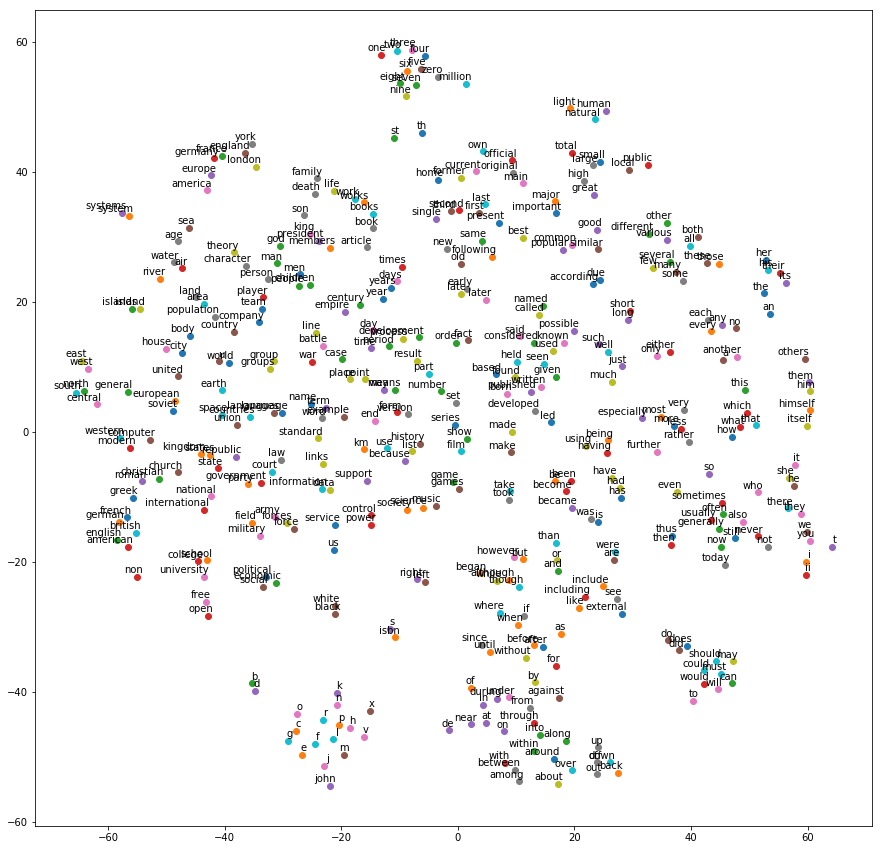

In [84]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)